# Advanced Lane Finding Project 

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## [Rubric](https://review.udacity.com/#!/rubrics/571/view) Points

### Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  


### Writeup / README

#### 1. Provide a Writeup / README that includes all the rubric points and how you addressed each one.  You can submit your writeup as markdown or pdf.  [Here](https://github.com/udacity/CarND-Advanced-Lane-Lines/blob/master/writeup_template.md) is a template writeup for this project you can use as a guide and a starting point. 

You're reading it!

### Camera Calibration

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.


I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `obj_points` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `img_points` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

I then used the output `obj_points` and `img_points` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` and use `cv2.getPerspectiveTransform` and `cv2.warpPerspective` functions to perform perspective transform the images. The sample results are in the end of this section. All the code are as below. 

        

### Imports

In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob 
import os 
import pickle

Use Opencv to find corners of all the images under folder `camera_cal`

In [21]:
nx = 9
ny = 6
CALIB_IMG_PATH = 'camera_cal/*jpg'
CALIB_OUT_IMG_PATH = 'output_images/chessboard_calib_output/'
calib_img_files = glob.glob(CALIB_IMG_PATH)


# Array to store images used in camera calibration
image_names   = []
images        = []
failed_images = [] # Images we could not find corners 
failed_image_names = [] # Images we could not find corners 

obj_points  = [] # 3D points in real world 3D space  
img_points  = [] # 2D points in image space 

objp = np.zeros((nx*ny, 3), dtype= np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)


for img_file in sorted(calib_img_files):
    image = cv2.imread(img_file)
    gray  = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    name  = img_file.split('/')[-1]
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    if ret:
        image_names.append(name)
        images.append(image)
        img_points.append(corners)
        obj_points.append(objp)
        # draw and display corners
#         image_copy = np.copy(image)
#         cv2.drawChessboardCorners(image_copy, (nx,ny), corners, ret)
        # plt.imshow(image)
        # plt.show()
    else:
        print('Unable to find board corners for image ' + name)
        failed_images.append(image)
        failed_image_names.append(name)
    

Unable to find board corners for image calibration1.jpg
Unable to find board corners for image calibration4.jpg
Unable to find board corners for image calibration5.jpg


As you can see from above prints, we could not find corners from some images. I displayed the those images below and you can see that those images were not properly taken and part of the chessboard are missing. As we request opencv to find `nx=9 * ny=6` corners, it does not suprise me that it fails here. 

### Draw corners on images

We successfully detected `nx*ny` corners in most of chessboard images. Now let's draw the detected corners on those image to make sure the results are correct.


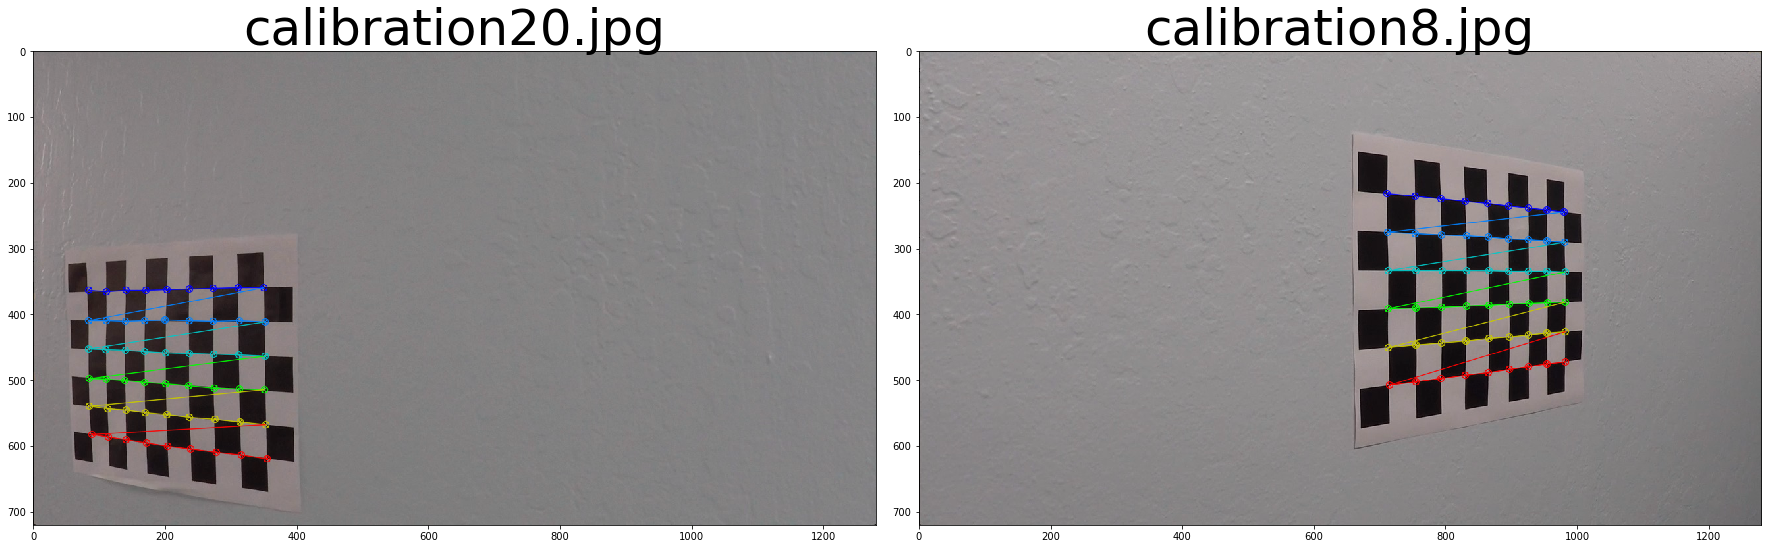

In [3]:
# Draw corners on chessboard images
# Randomly select 2 chessboard images and draw corners on it 
img_idxs = np.random.choice(len(images), 2)

img1 = np.copy(images[img_idxs[0]])
img2 = np.copy(images[img_idxs[1]])

cv2.drawChessboardCorners(img1, (nx,ny), img_points[img_idxs[0]], True)
cv2.drawChessboardCorners(img2, (nx,ny), img_points[img_idxs[1]], True)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img1)
ax1.set_title(image_names[img_idxs[0]], fontsize=50)

ax2.imshow(img2)
ax2.set_title(image_names[img_idxs[1]], fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()



### Show failed images

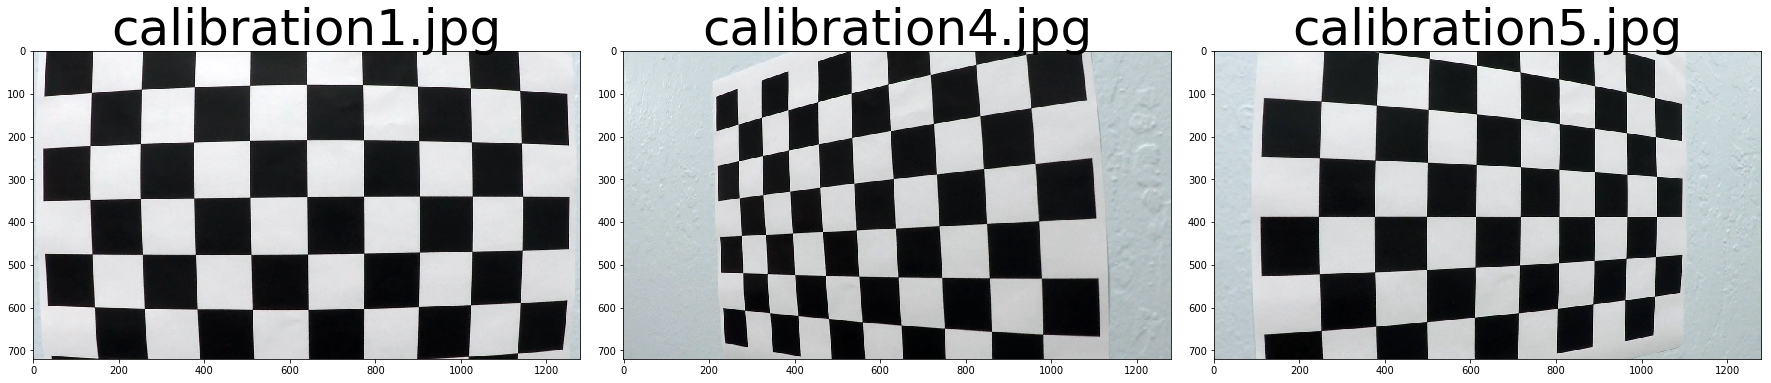

In [4]:
# Display chess board images which we could find coners 
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(failed_images[0])
ax1.set_title(failed_image_names[0], fontsize=50)
ax2.imshow(failed_images[1])
ax2.set_title(failed_image_names[1], fontsize=50)
ax3.imshow(failed_images[2])
ax3.set_title(failed_image_names[2], fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

### Undistort images

In [5]:
# Helper functions 
def concat_images(imga, imgb):
    """
    Combines two image ndarrays side-by-side.
    """
    ha,wa = imga.shape[:2]
    hb,wb = imgb.shape[:2]
    max_height = np.max([ha, hb])
    total_width = wa+wb
    new_img = np.zeros(shape=(max_height, total_width, 3), dtype=np.uint8)
    new_img[:ha,:wa]=imga
    new_img[:hb,wa:wa+wb]=imgb
    return new_img

In [15]:
def cal_undistort(img, objpoints, imgpoints):
    img_size = img.shape[:2][::-1]
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # undist = np.copy(img)  # Delete this line
    return undist

# performs image distortion correction and perspective transform for chessboard images 
def cal_undistort_warp(images, out_images_path, objpoints, imgpoints):
    """
    Undistort and warp image and saved as a side-by-side image.
    """
    if not os.path.exists(out_images_path):
        os.mkdir(out_images_path)
    undists = []
    warps = []
    for idx in range(len(images)-1):
        img = images[idx]
        img_size = img.shape[:2][::-1]
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
        
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        undists.append(undist)
        corners = imgpoints[idx]
        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        offset = 100
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])

        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(undist, M, img_size)
        warps.append(warped)
        concated = concat_images(img, undist)
        concated = concat_images(concated, warped)
        new_name = image_names[idx].split('.')[0] + '_warped' +'.jpg'
        new_name = out_images_path + new_name
        cv2.imwrite(new_name, concated)
    return undists, warps

In [7]:
udisted_imgs, warped_imgs = cal_undistort_warp(images, CALIB_OUT_IMG_PATH, obj_points, img_points)

#### Display undistored and warped images

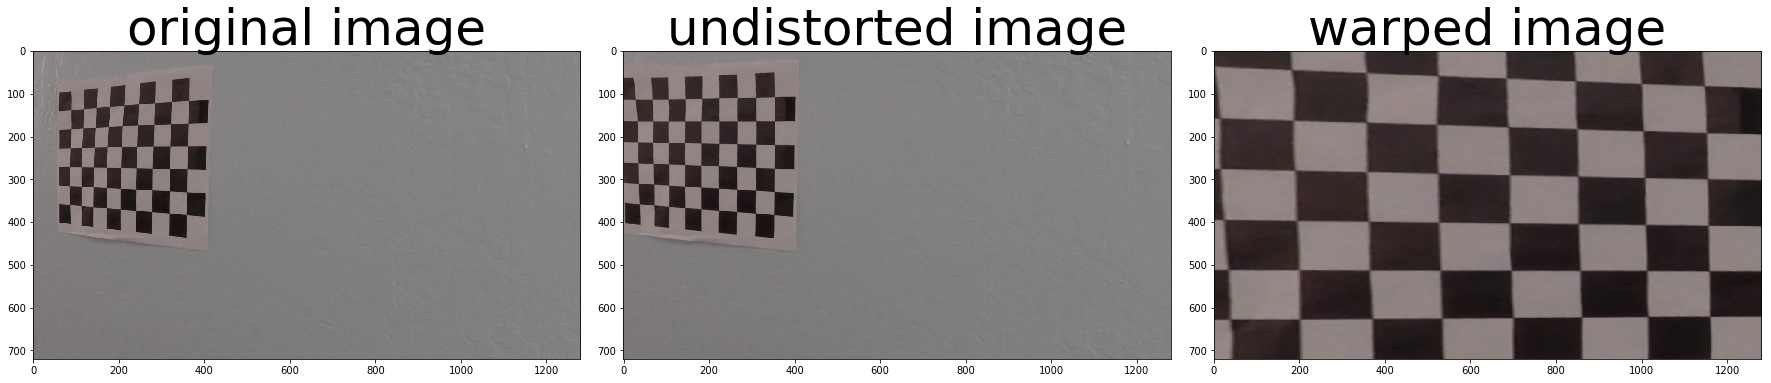

In [8]:
idx = np.random.randint(len(images))

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(images[idx])
ax1.set_title('original image', fontsize=50)

ax2.imshow(udisted_imgs[idx])
ax2.set_title('undistorted image', fontsize=50)

ax3.imshow(warped_imgs[idx])
ax3.set_title('warped image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

### Pipeline (test images)


#### 1. Provide an example of a distortion-corrected image.
To demonstrate this step, I will describe how I apply the distortion correction to one of the test images like this one


In [42]:
# Undistort all the image files under `tests_images`folder
out_path = 'output_images/test_images_undistored/'
in_path = 'test_images/'
test_img_files = glob.glob(in_path + '*jpg') + glob.glob(in_path + '*png')
for ifile in test_img_files:
    road_img = cv2.imread(ifile)
    udist = cal_undistort(road_img, obj_points, img_points)
    file_name = ifile.split('/')[-1]
    cv2.imwrite(out_path+file_name, udist)

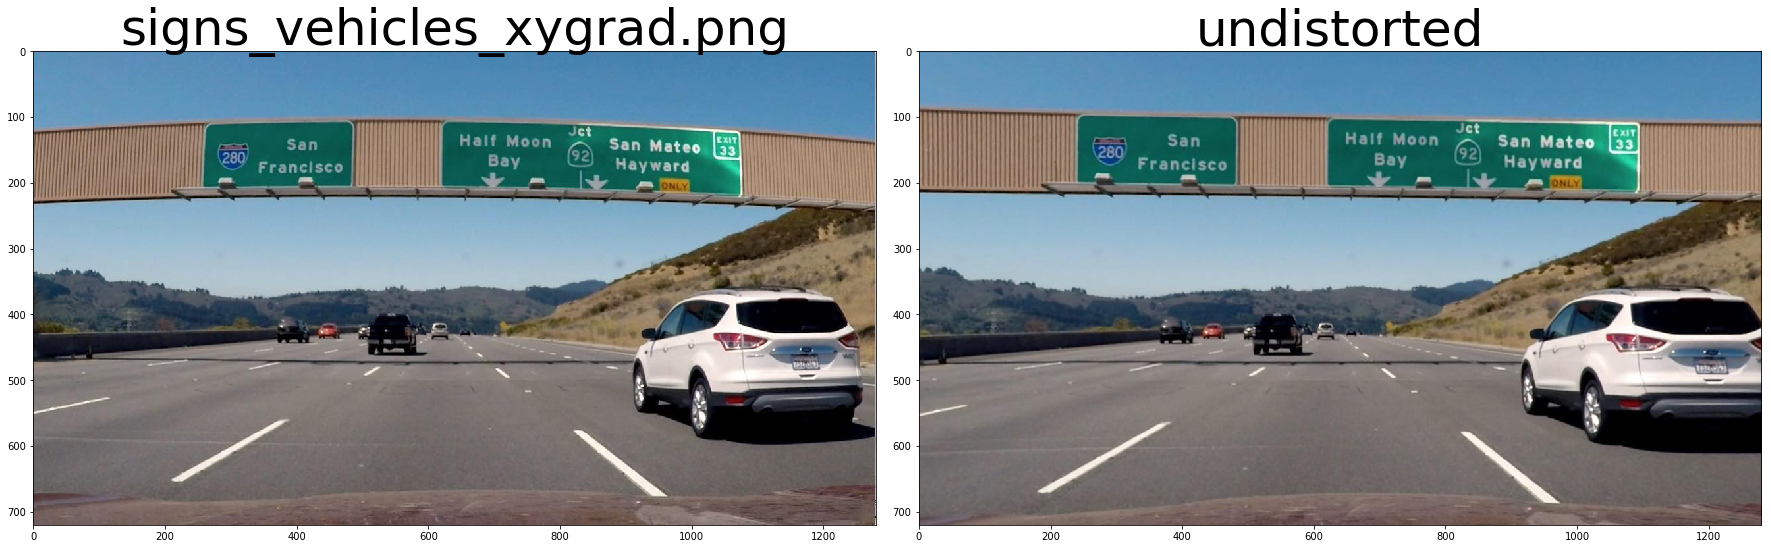

In [47]:
# Show original and undistorted road images side by side
road_img = cv2.imread(in_path + 'signs_vehicles_xygrad.png')
road_img_udist = cv2.imread(out_path + 'signs_vehicles_xygrad.png')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(road_img, cv2.COLOR_BGR2RGB))
ax1.set_title('signs_vehicles_xygrad.png', fontsize=50)
ax2.imshow(cv2.cvtColor(road_img_udist, cv2.COLOR_BGR2RGB))
ax2.set_title('undistorted', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()


### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.

I used a combination of color and gradient thresholds to generate a binary image (thresholding steps at lines # through # in another_file.py). Here's an example of my output for this step. (note: this is not actually from one of the test images)